In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import tensorflow as tf
import random
import gc

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, ReLU, BatchNormalization, Dropout
from tensorflow.keras.initializers import HeNormal, Ones, Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
SEED = 3126  
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
WIDTH, HEIGHT = 224, 224
BATCH_SIZE = 32
LEARNING_RATE = .005
EPOCHS = 50
DIR = "/kaggle/input/finalized-astrovision-data/denoised (1)/denoised"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=355,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)

train_generator = train_datagen.flow_from_directory(
    DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

Found 4607 images belonging to 4 classes.
Found 1534 images belonging to 4 classes.


In [4]:
def make_dense_layer(input_size, dropout_rate=0.0, input_shape=None):
    layers = []
    if input_shape:
        layers.append(Dense(input_size,
                            use_bias=False, 
                            input_shape=input_shape,
                            kernel_initializer=HeNormal()
                            ))
    else:
        layers.append(Dense(input_size, use_bias=False, kernel_initializer=HeNormal()))
    layers.extend([BatchNormalization(gamma_initializer=Ones(), beta_initializer=Constant(0.1)),
                  ReLU()])
    if dropout_rate > 0:
        layers.append(Dropout(dropout_rate))
    return Sequential(layers)

In [5]:
def build_model():
    base_model = ResNet152V2(weights=None, include_top=False,
                             input_shape=(WIDTH, HEIGHT, 3))
    base_model.trainable = True
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            new_weights = HeNormal()(layer.kernel.shape)
            layer.kernel.assign(new_weights)
            
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    fc_layers = Sequential([
        make_dense_layer(2048, input_shape=(x.shape[-1],), dropout_rate=.5),
        make_dense_layer(1024, dropout_rate=.1),
        make_dense_layer(512, dropout_rate=.1),
        make_dense_layer(8)
    ])
    x = fc_layers(x)
    predictions = Dense(train_generator.num_classes,
                        activation='softmax',
                        kernel_initializer=HeNormal())(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(LEARNING_RATE),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])   
    return model

In [6]:
model = build_model()

best_model_path = "/kaggle/working/best_model.keras"

checkpoint_callback = ModelCheckpoint(
    filepath=best_model_path,  
    monitor='val_loss',    
    save_best_only=True,       
    save_weights_only=False,    
    mode='min',                
    verbose=1                  
)

In [7]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()  
        gc.collect() 

In [8]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, ClearMemory()]
)

model = tf.keras.models.load_model(best_model_path)
initial_test_loss, initial_test_acc = model.evaluate(validation_generator, 
                                                     steps=validation_generator.samples // BATCH_SIZE)

print(f"Test Accuracy Before Fine-tuning: {initial_test_acc*100:.2f}%")

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3701 - loss: 1.3333
Epoch 1: val_loss improved from inf to 4.27363, saving model to /kaggle/working/best_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.3708 - loss: 1.3316 - val_accuracy: 0.5978 - val_loss: 4.2736
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.6572 - loss: 0.7081
Epoch 2: val_loss did not improve from 4.27363
144/144 ━━━━━━━━━━━━━━━━━━━━ 142s 893ms/step - accuracy: 0.6573 - loss: 0.7079 - val_accuracy: 0.3963 - val_loss: 4.6380
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.7182 - loss: 0.5898
Epoch 3: val_loss improved from 4.27363 to 2.21597, saving model to /kaggle/working/best_model.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 145s 923ms/step - accuracy: 0.7182 - loss: 0.5898 - val_accuracy: 0.4068 - val_loss: 2.2160
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.7192 - loss: 0.5961
Epoch 4: val_loss did not improve from 2.21597

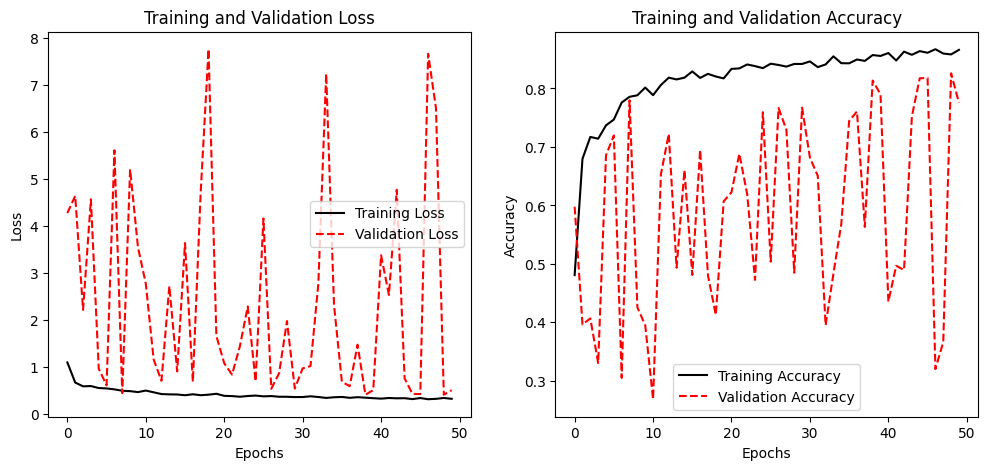

In [9]:
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
epochs_range = range(len(train_loss))

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss', color="black")
plt.plot(epochs_range, val_loss, label='Validation Loss', color="red", linestyle="--")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy', color="black")
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color="red", linestyle="--")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 537ms/step


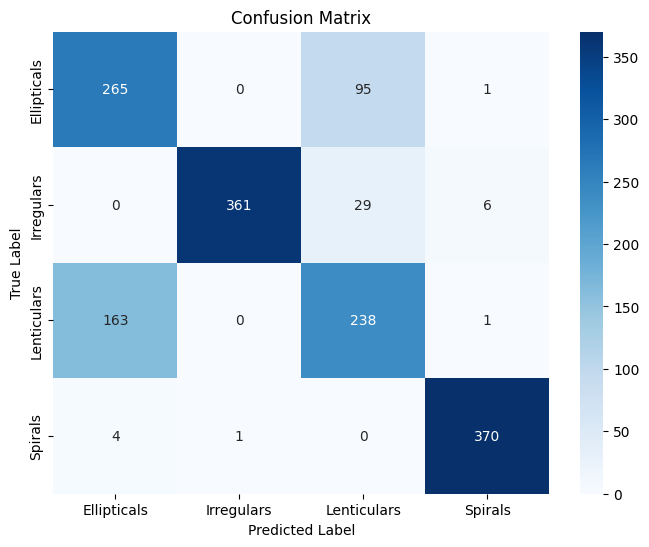

In [10]:
true_labels = validation_generator.classes  # Actual labels from the dataset

pred_probs  = model.predict(validation_generator)  # Probabilities
pred_labels = np.argmax(pred_probs, axis=1)  # Convert softmax to class indices

# Step 3: Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8,6))
sea.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()